In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut

# Regression Discontinuity Design (RDD)

In the problem set we are going to practice RDD in the Lee (2008) framework presented in the lecture 11. We employ the original simplified data set on the individual candidates for the US House of Representatives from 1946 to 1998. If a candidate obtains more votes than his or her competitors, he or she takes the office. Each elected candidate represents one of 435 congressional districts. The elections are held every two years. We seek the answer to the question whether winning the election has a causal influence on the probability that the candidate will win the next election.*

The observations of the data set **individ_final.dta** are clustered by district and election year. It consists of the following variables:*

- **outcome** is a treatment variable; it is coded as 1 if a candidate won the election in the corresponding year and 0 – otherwise.

- **outcomenext** is an outcome variable. It is coded as 1 if a candidate won the next election; as 0 if he or she did not win the next election; and as -1 if he or she did not participate in the next election.

- **difshare** is an assignment variable; it is the winning candidate’s vote share minus the vote share of the highest performing competitor. Therefore, 0 is the cutoff point: a candidate whose vote share is more than 0 is automatically assigned to treatment.

In [2]:
df = pd.read_stata("data/individ_final.dta")
df.head()

,year,outcome,outcomenext,difshare
0,1946,1,-1,0.061488
1,1946,0,0,-0.061488
2,1948,1,1,0.104869
3,1948,0,-1,-0.104869
4,1948,0,-1,-0.535721


## Task A

*What is the main assumption that makes RDD possible? Define the local randomization condition in the simplified setup presented in the lecture.*

Main assumption: agents are unable to precisely control the assignment variable near the known cutoff what leads to the randomized variation in treatment near the threshold.

local randomization.

The framework:
$$Y = D \tau + W \delta_1 + U$$
$$D = I(X \geq c)$$
$$X = W \delta_2 + V,$$

where:
- Y is the outcome of interest, 
- D is the binary treatment indicator, 
- W is the vector of all predetermined and observable characteristics of the individual that might impact Y and/or X,
- X is the assignment variable,
- c is the cutoff value

Individuals have imprecise control over X when conditional on W = w and U = u, the density of V (and hence X) is continuous. 

**Definition of Local Randomization:** If individuals have imprecise control over X, then Pr\[W = w,U = u|X = x\] is continuous in x: the treatment is “as good as” randomly assigned around the cutoff.

## Task B

A major advantage of the RD design over competing methods is its transparency, which can be illustrated using graphical methods. A standard way of graphing the data is to divide the assignment variable into a number of bins, making sure there are two separate bins on each side of the cutoff point. Then, the average value of the outcome variable can be computed for each bin and graphed against the mid-points of the bins.

## Task B.1

Create a new variable that groups the assignment variable values into 400 bins with a size of 0.005.

In [3]:
bins = np.linspace(-1, 1, num=401)
df["bin"] = pd.cut(df["difshare"], bins, labels=False, include_lowest=True)
df.sort_values(by="bin", inplace=True)

## Task B.2

Since we are interested in a causal influence on the probability that the candidate will win the next election based on winning the current election, drop the rows that do not have a comparable next election.

In [4]:
df = df[df["outcomenext"].isin([0, 1])]
df.head()

,year,outcome,outcomenext,difshare,bin
13050,1952,0,0,-0.996721,0
16761,1946,0,0,-0.999268,0
23171,1968,0,0,-0.901280,19
15113,1968,0,0,-0.853781,29
14899,1980,0,0,-0.809648,38


## Task B.3

Find the mean of the outcome variable for each bin or, in other words, local average. Draw this relationship on the scatterplot.

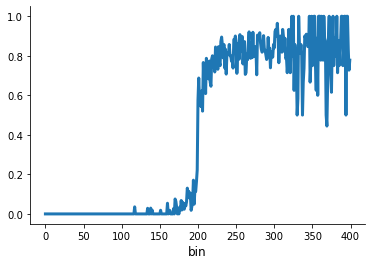

In [5]:
df.groupby("bin").mean()["outcomenext"].sort_index().plot()

## Task B.4

For better visuality we also add to the graph the fitted values of logistic regression around the cutoff. For this apply logistic regression separately on either side of the threshold (we take the bins with the share values from -0.25 to 0.25 and use the package LogisticRegression from sklearn.linear model). Extract probability estimates. Add them to the scatterplot in the proximity of cutoff. Do you observe a discontinuity at the cutoff point?

In [6]:
# split the sample into two parts before and after cutoff
cond = (df["difshare"] >= -0.25) & (df["difshare"] < 0)
df_left = df[cond]

cond = (df["difshare"] >= 0) & (df["difshare"] <= 0.25)
df_right = df[cond]


x_left = df_left["difshare"].values.reshape(-1, 1)
y_left = df_left["outcomenext"].values.reshape(-1, 1)
x_right = df_right["difshare"].values.reshape(-1, 1)
y_right = df_right["outcomenext"].values.reshape(-1, 1)

df_left.describe()

,year,outcome,outcomenext,difshare,bin
count,2424.000000,2424.0,2424.000000,2424.000000,2424.000000
mean,1967.764026,0.0,0.043317,-0.124739,174.548680
std,15.394885,0.0,0.203611,0.070788,14.162028
min,1946.000000,0.0,0.000000,-0.249781,150.000000
25%,1954.000000,0.0,0.000000,-0.184652,163.000000
50%,1964.000000,0.0,0.000000,-0.124836,175.000000
75%,1980.000000,0.0,0.000000,-0.062749,187.000000
max,1996.000000,0.0,1.000000,-0.000056,199.000000


/home/peisenha/local/anaconda3/envs/teaching-microeconometrics/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/peisenha/local/anaconda3/envs/teaching-microeconometrics/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


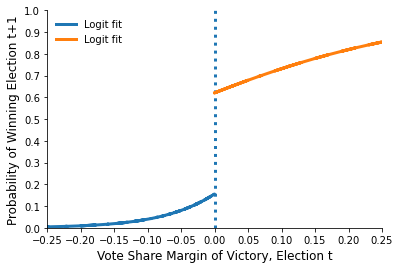

In [7]:
# apply Logistic Regression and extract propensity score
lr_left = LogisticRegression(solver="newton-cg", C=1e20)
lr_left.fit(df_left[["difshare"]], y_left)
prob_left = lr_left.predict_proba(df_left[["difshare"]])[:, 1]
lr_right = LogisticRegression(solver="newton-cg", C=1e20)
lr_right.fit(x_right, y_right)
prob_right = lr_right.predict_proba(x_right)[:, 1]

# draw the plot
fig, ax = plt.subplots()
ax.set_xlim(-0.25, 0.25)
ax.set_xticks(np.arange(-0.25, 0.251, step=0.05))
ax.set_ylim(0.0, 1.0)
ax.set_yticks(np.arange(0.0, 1.01, step=0.1))
# dfm = dfm[(dfm["difshare"] >= -0.25) & (dfm["difshare"] <= 0.25)]
# x = np.linspace(-0.25, 0.25, num=100)
# ax.scatter(x, dfm["outcomenext"], label="Local Average")
ax.axvline(0.0, linestyle=":")
ax.plot(x_left, prob_left, label="Logit fit")
ax.plot(x_right, prob_right, label="Logit fit")
ax.set_xlabel("Vote Share Margin of Victory, Election t")
ax.set_ylabel("Probability of Winning Election t+1")
ax.legend()

plt.show()

In [8]:
# prob_left = lr_left.predict_proba(x_left)[:, 1]
# lr_right = LogisticRegression(solver="newton-cg", C=1e20)
# lr_right.fit(x_right, y_right)
# prob_right = lr_right.predict_proba(x_right)[:, 1]

# draw the plot
# fig, ax = plt.subplots()
# ax.set_xlim(-0.25, 0.25)
# ax.set_xticks(np.arange(-0.25, 0.251, step=0.05))
# ax.set_ylim(0.0, 1.0)
# ax.set_yticks(np.arange(0.0, 1.01, step=0.1))
# dfm = dfm[(dfm["difshare"] >= -0.25) & (dfm["difshare"] <= 0.25)]
# x = np.linspace(-0.25, 0.25, num=100)
# ax.scatter(x, dfm["outcomenext"], label="Local Average")
# ax.axvline(0.0, linestyle=":")
# ax.plot(x_left, prob_left, label="Logit fit")
# ax.plot(x_right, prob_right, label="Logit fit")
# ax.set_xlabel("Vote Share Margin of Victory, Election t")
# ax.set_ylabel("Probability of Winning Election t+1")
# ax.legend()

# plt.show()

In [9]:
raise AssertionError

AssertionError: 

## Task C

*LLR as a method restricts the estimation to observations close to the cutoff. It is based on the assumption that regression lines within the bins around the cutoff point are close to linear. That helps to avoid some of the drawbacks of other parametric/non-parametrics approaches (Lee & Lemieux (2010))*

*Run the LLR with a specification $Y = \alpha_r + \tau D + \beta X + \gamma X D + \epsilon $, where $X$ is rectricted by a bandwidth: $h ≥ X ≥ −h$. Interpret the result. Experiment with few bandwidths on your choice.*

In [ ]:
for h in [0.25, 0.2, 0.1, 0.05, 0.01]:
    dfreg = df[df["difshare"].between(-h, h)]
    rslt = smf.ols(formula="outcomenext ~ outcome + difshare + difshare*outcome", data=dfreg).fit()
    info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
    print(" Bandwidth: {:>4}   Effect {:5.3f}%    pvalue {:5.3f}".format(*info))

## Task D

*As you might find, the treatment effect result is sensitive to the bandwidth choice. In general, choosing a bandwidth in estimation involves finding an optimal balance between precision and bias. One the one hand, using a larger bandwidth yields more precise estimates as more observations are available to estimate the regression. On the other hand, the linear specification is less likely to be accurate (Lee & Lemieux (2010)).*

*We are going to review one of the approaches for choosing a bandwidth – cross-validation “leave one out” procedure. The main idea is to take an observation i in the data, leave it out, run LLR, and use the estimates to predict the value of $Y$ at $X = X_i$. Proceeding with each observation separately on each side of the cutoff, we obtain the predicted values of $Y$ that can be compared to the actual values. The optimal bandwidth is then a value of $h$ that minimizes the mean square of the difference between the predicted and actual values of $Y$. And overall mean square error is simply the average of the squares of the prediction errors on each side of the cutoff.*

*If you want to practice your Python skills, we recommend to work with the packages LeaveOneOut() and cross_val_score from sklearn.model selection and to write the code that finds the optimal bandwidth. Otherwise, we created our draft in auxiliary.py; you can use it to produce your solution. Draw the graph showing the relationship between the bandwidth and the mean square error. What is the optimal bandwidth for LLR in our framework?*

In [ ]:
# create two sides around the cutoff
df_right = df
df_left = df[(df["difshare"] >= -0.5) & (df["difshare"] < 0)]
df_right = df_right[(df_right["difshare"] >= 0) & (df_right["difshare"] <= 0.5)]
# create necessary arrays
position = np.linspace(0, 99, num=100).astype(int)
width_left = np.linspace(199, 100, num=100).astype(int)
error_mean_left = np.linspace(0, 0, num=100)
width_right = np.linspace(200, 299, num=100).astype(int)
error_mean_right = np.linspace(0, 0, num=100)
# run cross-validation on each side
for h, p in zip(width_left, position):
    dfreg = df_left[(df_left["bin"] >= h)]
    X = dfreg["difshare"].values.reshape(-1, 1)
    y = dfreg["outcomenext"].values.reshape(-1, 1)
    loocv = LeaveOneOut()
    model = LinearRegression()
    results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=loocv)
    error_mean_left[p] = results.mean() * (-1)
for h, p in zip(width_right, position):
    dfreg = df_right[(df_right["bin"] <= h)]
    X = dfreg["difshare"].values.reshape(-1, 1)
    y = dfreg["outcomenext"].values.reshape(-1, 1)
    loocv = LeaveOneOut()
    model = LinearRegression()
    results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=loocv)
    error_mean_right[p] = results.mean() * (-1)

In [ ]:
# find mean error on both sides of the cutoff and plot it
error_mean_right_corr = error_mean_right[::-1]
error = (error_mean_left + error_mean_right_corr) / 2
bandwidth = np.linspace(0, 0.5, num=100)
fig, ax = plt.subplots()
ax.plot(bandwidth, error)
ax.set_xlabel("Bandwidth")
ax.set_ylabel("Mean squared error")
plt.show()

In [ ]:
df = pd.DataFrame({"bandwidth": bandwidth, "error": error}, columns=["bandwidth", "error"])
df = df[df.error == df.error.min()]
print(" Optimal bandwidth: {:5.3f}".format(df.iloc[0, 0]))

## References

- Lee, D. S. (2008). [Randomized experiments from non-random selection in us house elections](https://www.sciencedirect.com/science/article/abs/pii/S0304407607001121). *Journal of Econometrics, 142*(2), 675–697.

- Lee, D. S., & Lemieux, T. (2010). [Regression discontinuity designs in economics](https://www.aeaweb.org/articles?id=10.1257/jel.48.2.281). *Journal of Economic Literature, 48*, 281-355.